In [1]:
# Author: Lee Yat Shun, Jasper
# Copyright (c) 2023 Lee Yat Shun, Jasper. All rights reserved.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from caviar import CaviarModel
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df = df.set_index('Date')
df.head()

,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
Date,,,,,,,,,,,,,
1993-01-29,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1993-02-01,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
1993-02-02,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
1993-02-03,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
1993-02-04,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [5]:
returns = df['Log Return'].dropna()
low_open_log_difference = (df['PX_LOW'].apply(lambda x: np.log(x)) - df['PX_OPEN'].apply(lambda x: np.log(x))).dropna()

## Numeric

In [6]:
in_samples = returns[2000:-2000] * 100
out_of_samples = returns[-2000:] * 100

In [7]:
# initiate parameter
quantile = 0.05 # 5% VAR

In [8]:
# instantiation
caviar_model = CaviarModel(quantile, model='asymmetric', method='mle')
caviar_model

CaviarModel(quantile=0.05, model=asymmetric, method=mle, G=10, tol=1e-10, LAGS=4)

In [9]:
caviar_model.fit(in_samples)

Update 1: -3840.7104167177686
Final loss: 0.12481609070631304
Time taken(s): 6.29


In [10]:
caviar_model.summary()

,coefficient,S.E. of beta,pval of beta
beta1,-0.042760,0.007853,2.592507e-08
beta2,0.927475,0.020674,0.000000e+00
beta3,-0.009356,0.042921,4.137248e-01
beta4,0.217554,0.087711,6.562909e-03


### Backtesting on the out of samples

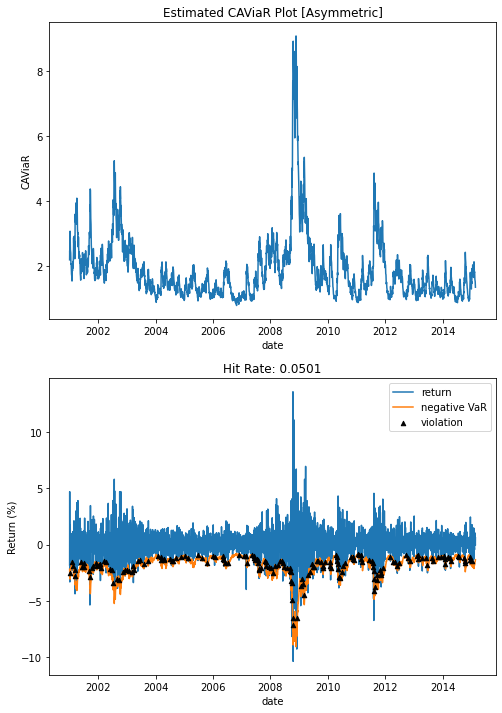

In [11]:
# in sample
caviar_model.plot_caviar(in_samples, 'in')

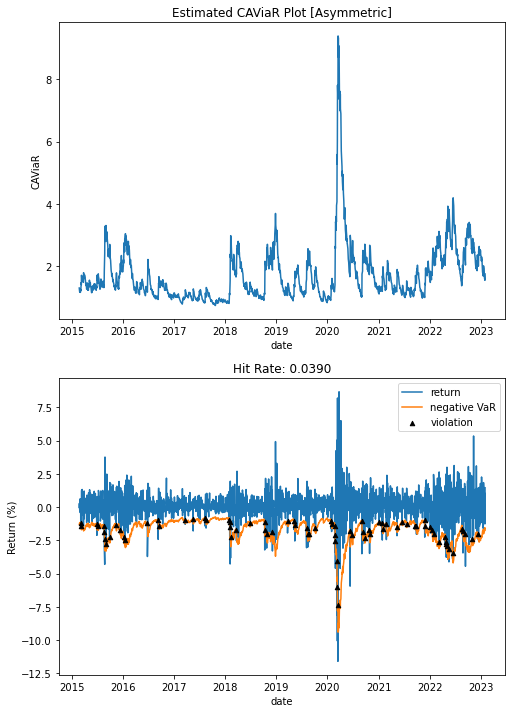

In [12]:
# out of sample
caviar_model.plot_caviar(out_of_samples, 'out')

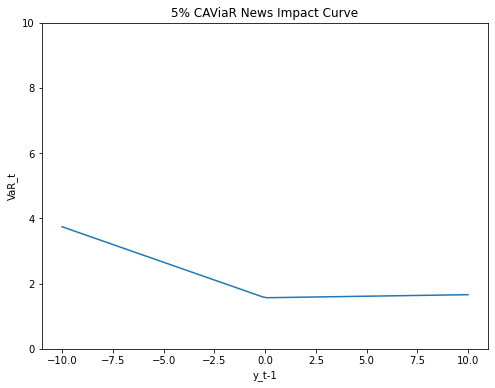

In [13]:
caviar_model.plot_news_impact_curve(VaR=-1.645)

### VaR Test

In [14]:
in_VaR = caviar_model.predict(in_samples, caviar_model.VaR0_in)

In [15]:
out_VaR = caviar_model.predict(out_of_samples, caviar_model.VaR0_out)

In [26]:
(in_samples < in_VaR[:-1]).value_counts(normalize=True)

False    0.94993
True     0.05007
Name: Log Return, dtype: float64

In [16]:
(out_of_samples < out_VaR[:-1]).value_counts(normalize=True)

False    0.961
True     0.039
Name: Log Return, dtype: float64

In [17]:
# The null hypothesis states that the current VaR violations are uncorrelated with past violations.

print(caviar_model.dq_test(in_samples, 'in'))
print(caviar_model.dq_test(out_of_samples, 'out'))

0.25808779677618554
0.9992693528052147


In [18]:
# H0: the obs ~ binomial(p)

print(binomial_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(binomial_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

0.9693038363544069
0.023813268561027216


In [19]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(kupiec_pof_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

1.0
1.0


In [20]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(in_samples, in_VaR[:-1]))
print(christoffersen_test(out_of_samples, out_VaR[:-1]))

0.5155453367851368
0.7177817639296461


### Forecast

In [24]:
if len(out_VaR)-1 == len(out_of_samples):
    print('Day T+1 VaR forecast:', out_VaR[-1])

Day T+1 VaR forecast: -1.678287074519768


### Mean reversion property?

count    78.000000
mean      0.254580
std       1.771607
min      -4.301879
25%      -0.492719
50%       0.215138
75%       1.060368
max       8.202780
Name: Log Return, dtype: float64
Date
2015-03-09    1.004136
2015-03-11    1.001783
2015-06-30    1.003878
2015-07-09    1.005692
2015-08-21    0.974953
                ...   
2022-08-23    1.235700
2022-08-29    1.227502
2022-09-14    1.232177
2022-11-03    1.219424
2022-12-16    1.204943
Name: Log Return, Length: 78, dtype: float64


<AxesSubplot:ylabel='Frequency'>

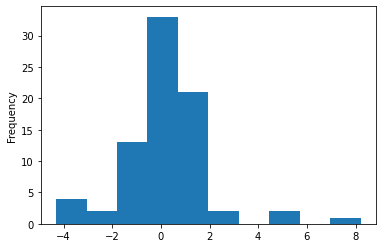

In [32]:
the_following_day = np.array(range(2000))[out_of_samples < out_VaR[:-1]] + 1

print(out_of_samples.iloc[the_following_day].describe())
print((out_of_samples.iloc[the_following_day]/100 + 1).cumprod())

out_of_samples.iloc[the_following_day].plot.hist()

### Backtesting

In [22]:
out_low_open_log_difference = low_open_log_difference.loc[out_of_samples.index]
(out_low_open_log_difference * 100 < out_VaR[:-1]).value_counts(normalize=True)

False    0.9475
True     0.0525
dtype: float64

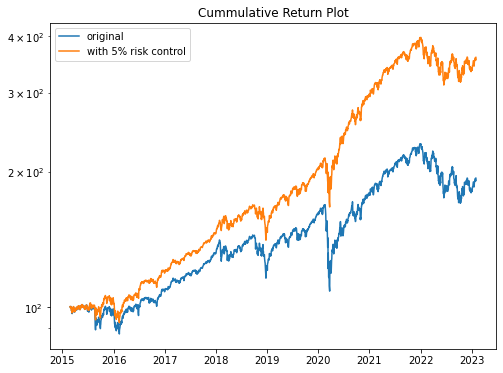

In [23]:
# with 0.2% transaction cost

backtest(out_of_samples, out_low_open_log_difference, out_VaR[:-1], caviar_model.quantile, ntl=100, penalty=0.002)